# 1. Import Dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

## How to get new data
Remember to do a backup before to proceed, look at backup\appunti.txt.

To generate new data pen scripts\getDataHandGesture.py and edit labels adding new gestures. 

Execute it to export data in src\dataHandGesture

## How to export and use the generated model
At the end of the execution the generated model will be here: Tensorflow\workspace\models

Then, copy the name of the folder inside Tensorflow\workspace\models\my_hand_gesture_model\ (not eval, should be something like 1642800231) and paste in
scripts\handGestureModule.py in the first variable named "lastModel"

## Dataset
This specific dataset seperates hand gestures into 4 different classes.

- stop
- onefingerup
- twofingerup
- thumbsup

The information about each hand gesture is contained into 42 features.

In [2]:
CSV_COLUMN_NAMES = np.arange(43)
CSV_COLUMN_NAMES = [str(item) for item in CSV_COLUMN_NAMES]
CSV_COLUMN_NAMES[42] = "Species"
SPECIES = ['backward', 'detect', 'down', 'forward', 'land', 'left', 'ok', 'right', 'stop', 'up']
CSV_PATH = os.path.join("src", "dataHandGesture", "file_0.csv")

In [3]:
df = pd.read_csv(CSV_PATH, names=CSV_COLUMN_NAMES, header=0)
train=df.sample(frac=0.8,random_state=200) #random state is a seed value
test=df.drop(train.index)

In [4]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,Species
674,-0.627156,-0.237030,-0.577802,0.087291,-0.394490,0.418663,-0.281683,0.700682,-0.274632,0.961549,...,-0.244080,-0.027866,-0.462645,0.254153,-0.427393,0.141345,-0.434443,0.014437,-0.441493,6.0
233,-0.415663,0.819089,-0.008018,0.774779,0.257838,0.446891,0.346457,0.101278,0.346457,-0.137992,...,0.039245,-0.513144,0.119002,-0.380216,-0.297505,-0.415663,-0.146854,-0.442249,0.048107,2.0
739,-0.777230,-0.629216,-0.261386,-0.364681,0.228004,-0.166279,0.518993,0.005669,0.704168,0.177617,...,0.481832,-0.578829,-0.219186,-0.525922,0.071803,-0.499468,0.283431,-0.473014,0.415699,7.0
865,-0.386138,-0.922441,0.185643,-0.749174,0.653465,-0.437293,0.774752,-0.056106,0.514851,0.099835,...,-0.108086,-0.680692,0.151815,-0.576732,0.307755,-0.542078,0.013201,-0.594058,-0.073432,8.0
523,-0.112126,-0.993694,-0.281323,-0.683500,-0.323622,-0.316908,-0.267223,-0.049013,-0.182625,0.148383,...,0.444477,0.367264,-0.345107,0.451862,-0.049013,0.508261,0.162482,0.550560,0.345779,5.0


In [5]:
train_y = train.pop('Species')
test_y = test.pop('Species')
train_y = train_y.apply(np.int32)
test_y = test_y.apply(np.int32)
train.head() # the species column is now gone

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
674,-0.627156,-0.237030,-0.577802,0.087291,-0.394490,0.418663,-0.281683,0.700682,-0.274632,0.961549,...,0.042639,-0.244080,-0.027866,-0.462645,0.254153,-0.427393,0.141345,-0.434443,0.014437,-0.441493
233,-0.415663,0.819089,-0.008018,0.774779,0.257838,0.446891,0.346457,0.101278,0.346457,-0.137992,...,-0.229564,0.039245,-0.513144,0.119002,-0.380216,-0.297505,-0.415663,-0.146854,-0.442249,0.048107
739,-0.777230,-0.629216,-0.261386,-0.364681,0.228004,-0.166279,0.518993,0.005669,0.704168,0.177617,...,-0.129118,0.481832,-0.578829,-0.219186,-0.525922,0.071803,-0.499468,0.283431,-0.473014,0.415699
865,-0.386138,-0.922441,0.185643,-0.749174,0.653465,-0.437293,0.774752,-0.056106,0.514851,0.099835,...,-0.282178,-0.108086,-0.680692,0.151815,-0.576732,0.307755,-0.542078,0.013201,-0.594058,-0.073432
523,-0.112126,-0.993694,-0.281323,-0.683500,-0.323622,-0.316908,-0.267223,-0.049013,-0.182625,0.148383,...,0.310865,0.444477,0.367264,-0.345107,0.451862,-0.049013,0.508261,0.162482,0.550560,0.345779


In [6]:
train.shape  # we have 800 entires with 42 features

(799, 42)

EDA
We'll just do a few quick plots of the data.

In [7]:
import seaborn as sns # data visualization library  

## Input Function
Remember that nasty input function we created earlier. Well we need to make another one here! Fortunatly for us this one is a little easier to digest.

In [8]:
def input_fn(features, labels, training=True, batch_size=256):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

In [9]:
# Feature columns describe how to use the input.
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))

# 2. Building the Model
And now we are ready to choose a model. For classification tasks there are variety of different estimators/models that we can pick from. Some options are listed below.

- DNNClassifier (Deep Neural Network)
- LinearClassifier

We can choose either model but the DNN seems to be the best choice. This is because we may not be able to find a linear coorespondence in our data.

In [10]:
MODEL_PATH = os.path.join("Tensorflow", "workspace", "models", "my_hand_gesture_model_test")

In [11]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between len(SPECIES) classes.
    n_classes=len(SPECIES),
    activation_fn=lambda x: tf.nn.leaky_relu(x, alpha=0.01),
    optimizer=lambda: tf.keras.optimizers.Adam(
           learning_rate=tf.compat.v1.train.exponential_decay(
               learning_rate=0.1,
               global_step=tf.compat.v1.train.get_global_step(),
               decay_steps=10000,
               decay_rate=0.96)
       ),
    model_dir= MODEL_PATH)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'Tensorflow\\workspace\\models\\my_hand_gesture_model_test', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Training

In [12]:
classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=3000)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into Tensorflow\workspace\models\my_hand_gesture_model_test\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 2.3688512, step = 0
INFO:tensorflow:global_step/sec: 57.7001
INFO:tensorflow:loss = 0.06823605, step = 100 (1.735 sec)
INFO:tensorflow:global_step/sec: 92.6731
INFO:tensorflow:loss = 0.060681835, step = 200 (1.079 sec)
INFO:tensorflow:global_step/sec: 85.1015
INFO:tensorflow:loss = 0.054402404, step = 300 (1.174 sec)
INFO:ten

## Export Model

In [13]:
# To export
feature_spec = tf.feature_column.make_parse_example_spec(my_feature_columns)
export_input_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(feature_spec)
export_path = classifier.export_saved_model(MODEL_PATH, export_input_fn, as_text=True)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: ['serving_default', 'classification']
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from Tensorflow\workspace\models\my_hand_gesture_model_test\model.ckpt-3000
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: Tensorflow\workspace\models\my_hand_gesture_model_test\temp-1643159882\saved_model.pbtxt


## Load Model

In [14]:
# Loading the estimator
predict_fn = tf.saved_model.load(export_path).signatures['predict']
predict_fn

<ConcreteFunction pruned(examples) at 0x3B734370>

In [15]:
# Convert input data into serialized Example strings.
examples = []
for index, row in test.iterrows():
    feature = {}
    for col, value in row.iteritems():
        feature[col] = tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
    example = tf.train.Example(
        features=tf.train.Features(
            feature=feature
        )
    )
    examples.append(example.SerializeToString())

# Convert from list to tensor
examples = tf.constant(examples)

print(test)
print(feature)

            0         1         2         3         4         5         6  \
0   -0.259707  0.965687  0.207766  0.820993  0.374721  0.375781  0.129854   
2   -0.321922  0.946766  0.099888  0.775762  0.236692  0.342551  0.031486   
6   -0.382369  0.904317  0.055617  0.792012  0.246535  0.365256  0.033157   
7   -0.400819  0.916157  0.059936  0.792540  0.262218  0.354262  0.048698   
10  -0.426505  0.904485  0.036768  0.783152  0.246344  0.352970  0.047798   
..        ...       ...       ...       ...       ...       ...       ...   
987 -0.261952 -0.881557  0.207466 -0.690855  0.544861 -0.441477  0.794239   
990 -0.429525 -0.630162  0.057222 -0.508476  0.452703 -0.173838  0.726498   
993 -0.524475 -0.384897 -0.269111 -0.529234  0.141693 -0.540336  0.452572   
995 -0.596513 -0.802604 -0.327698 -0.910130 -0.005120 -0.883248  0.290576   
996 -0.402409 -0.629288  0.015719 -0.563268  0.411840 -0.365207  0.697928   

            7         8         9  ...        32        33        34  \
0  

In [16]:
# https://stackoverflow.com/questions/46766606/how-i-get-accurcy-graphnot-dot-like-loss-graph-in-tensorboard

# make predictions of all testset
predictions = predict_fn(examples=examples)
print(predictions)

{'all_class_ids': <tf.Tensor: shape=(200, 10), dtype=int32, numpy=
array([[0, 1, 2, ..., 7, 8, 9],
       [0, 1, 2, ..., 7, 8, 9],
       [0, 1, 2, ..., 7, 8, 9],
       ...,
       [0, 1, 2, ..., 7, 8, 9],
       [0, 1, 2, ..., 7, 8, 9],
       [0, 1, 2, ..., 7, 8, 9]])>, 'classes': <tf.Tensor: shape=(200, 1), dtype=string, numpy=
array([[b'0'],
       [b'0'],
       [b'0'],
       [b'0'],
       [b'0'],
       [b'0'],
       [b'0'],
       [b'0'],
       [b'0'],
       [b'0'],
       [b'0'],
       [b'0'],
       [b'0'],
       [b'0'],
       [b'0'],
       [b'2'],
       [b'0'],
       [b'0'],
       [b'0'],
       [b'0'],
       [b'0'],
       [b'0'],
       [b'0'],
       [b'0'],
       [b'1'],
       [b'1'],
       [b'1'],
       [b'1'],
       [b'1'],
       [b'1'],
       [b'1'],
       [b'1'],
       [b'1'],
       [b'1'],
       [b'1'],
       [b'1'],
       [b'1'],
       [b'1'],
       [b'1'],
       [b'1'],
       [b'4'],
       [b'4'],
       [b'4'],
       [b'1'],
      

In [17]:
# print results
for idx, resultPred in enumerate(predictions["class_ids"]):
    class_id = resultPred[0]
    probability = predictions['probabilities'][idx][class_id]
    print(probability)
    print(f"\tPrediction is {SPECIES[class_id]} {100 * probability :.2f}%")
    print(f"\tExpected: {SPECIES[test_y.iloc[idx]]}")

tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expected: backward
tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expected: backward
tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expected: backward
tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expected: backward
tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expected: backward
tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expected: backward
tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expected: backward
tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expected: backward
tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expected: backward
tf.Tensor(0.97266364, shape=(), dtype=float32)
	Prediction is backward 97.27%
	Expected: backward
tf.Tensor(0.99999475, shape=(), dtype=float32)
	Prediction is backward 100

## Evaluation

In [18]:
# tensorboard --logdir .
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False), steps=1)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-01-26T02:18:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from Tensorflow\workspace\models\my_hand_gesture_model_test\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Inference Time : 0.36102s
INFO:tensorflow:Finished evaluation at 2022-01-26-02:18:07
INFO:tensorflow:Saving dict for global step 3000: accuracy = 0.96, average_loss = 0.5249, global_step = 3000, loss = 0.5249
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: Tensorflow\workspace\models\my_hand_gesture_model_test\model.ckpt-3000


In [19]:
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))
eval_result


Test set accuracy: 0.960



{'accuracy': 0.96, 'average_loss': 0.5249, 'loss': 0.5249, 'global_step': 3000}

## Predictions
Now that we have a trained model it's time to use it to make predictions. I've written a little script below that allows you to type the features of a flower and see a prediction for its class.

In [20]:
def input_fn(features, batch_size=256):
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = CSV_COLUMN_NAMES[:-1]
predict = {}

for rowNum in range(5):
    expected = SPECIES[test_y.iloc[rowNum]]
    for idx, feature in enumerate(features):
      predict[feature] = [test.iloc[rowNum][idx]] #to predict the first row of test

    predictions = classifier.predict(input_fn=lambda: input_fn(predict))
    for pred_dict in predictions:
        class_id = pred_dict['class_ids'][0]
        probability = pred_dict['probabilities'][class_id]

        print("\n")
        print('Prediction is "{}" ({:.1f}%)'.format(
            SPECIES[class_id], 100 * probability))
        print(f"Expected is {expected}")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from Tensorflow\workspace\models\my_hand_gesture_model_test\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Prediction is "backward" (100.0%)
Expected is backward
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from Tensorflow\workspace\models\my_hand_gesture_model_test\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Prediction is "backward" (100.0%)
Expected is backward
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from Tensorflow\workspace\models\my_hand_gesture_model_test\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorf

# (NEW ADDED 26/01/2022) Evaluating model performance

https://www.kaggle.com/riteshsinha/tensorflow-2-classifying-tumors-deep-learning

https://www.kaggle.com/karthickaravindan/dnnclassifier

In [21]:
# Prediction is done here now.
predictions = list(predict_fn(examples=examples)["class_ids"].numpy().T[0])

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [23]:
cm = confusion_matrix(test_y, predictions)
print(cm)

[[23  0  1  0  0  0  0  0  0  0]
 [ 0 21  0  0  3  0  0  0  0  0]
 [ 0  0 19  0  0  0  0  2  0  0]
 [ 0  0  0 21  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  0  0  0]
 [ 0  0  0  0  0 19  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0]
 [ 0  0  0  0  0  0  0 16  1  0]
 [ 0  0  0  0  0  0  0  0 16  0]
 [ 0  1  0  0  0  0  0  0  0 20]]


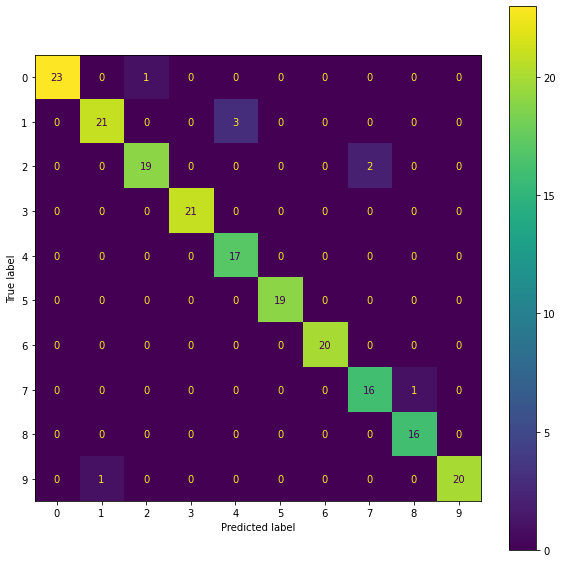

In [24]:
cmp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10,10)) # set size
cmp.plot(ax=ax)
plt.show()

In [25]:
print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        24
           1       0.95      0.88      0.91        24
           2       0.95      0.90      0.93        21
           3       1.00      1.00      1.00        21
           4       0.85      1.00      0.92        17
           5       1.00      1.00      1.00        19
           6       1.00      1.00      1.00        20
           7       0.89      0.94      0.91        17
           8       0.94      1.00      0.97        16
           9       1.00      0.95      0.98        21

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



In [26]:
accuracy_score(test_y, predictions, normalize=True, sample_weight=None)

0.96